In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, early_stopping
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import shap

In [158]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

# Parte 1

In [159]:
df_hr = pd.read_csv('Data/hr_role.csv')
df_hr['Attrition'] = df_hr['Attrition'].map({'Yes': 1, 'No': 0})
df_hr = pd.get_dummies(df_hr)


In [160]:
target = 'Attrition'
X = df_hr.copy()
X = X.drop(columns=[target])
y = df_hr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA 

In [161]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [162]:
objeto_pca = pipeline.named_steps['pca']

In [163]:
X_pca = pipeline.transform(X)
X_componentes = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X.shape[1])])
X_componentes.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,-0.030304,2.330446,-1.161395,3.217517,-0.113925,-0.253495,-1.040500,-0.309246,-0.448044,-2.111620,...,0.014891,7.021017e-16,-4.196757e-16,1.557119e-15,-6.386010e-16,4.196947e-16,-4.439226e-16,-4.944891e-16,-2.552172e-16,-1.479499e-16
1,0.049651,-1.543678,-0.213908,-1.662470,0.719564,2.208041,1.095471,1.080794,2.427347,-1.248215,...,-0.102855,-3.506487e-16,-5.087771e-16,-4.860947e-16,1.069790e-15,5.818953e-16,4.751109e-16,1.562116e-16,1.214602e-16,2.081245e-16
2,-2.921983,-0.996320,-0.206778,1.584724,-0.095803,-0.098296,-2.782596,-0.838934,0.416457,0.642975,...,-0.099216,7.298573e-16,-6.972314e-16,6.689407e-16,8.046889e-16,1.085828e-15,-1.221079e-15,-8.830672e-16,5.590343e-16,6.847174e-16
3,-1.187400,-1.054261,-0.692836,2.306721,-0.228501,2.392424,1.058589,0.071526,-1.843889,-1.818120,...,0.045951,-8.036383e-16,-1.377243e-15,1.390586e-15,9.157112e-16,-2.464391e-16,9.993673e-16,-1.105112e-15,5.210812e-16,3.794060e-16
4,-2.122667,-1.196360,0.532758,-1.288092,-0.694017,-1.685820,-0.501539,-0.272690,-0.631277,1.714992,...,0.148985,-1.841152e-16,4.210346e-16,-4.305835e-16,7.058972e-17,-5.648298e-17,3.102173e-17,-1.009523e-15,4.840632e-16,-1.249424e-16


In [180]:
explained_variance = objeto_pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
})
explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Ratio', ascending=False)
top_10_explained_variance = explained_variance_df.head(10).reset_index(drop=True)
top_10_explained_variance


,Principal Component,Explained Variance Ratio
0,PC1,0.104945
1,PC2,0.068745
2,PC3,0.051695
3,PC4,0.042252
4,PC5,0.041221
5,PC6,0.039242
6,PC7,0.038350
7,PC8,0.035444
8,PC9,0.034967
9,PC10,0.031601


# KMeans

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

Text(0, 0.5, 'Inertia')

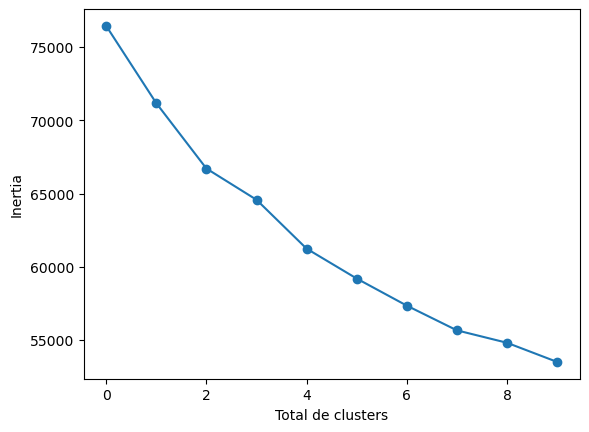

In [165]:
inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(df_hr)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker='o')
plt.xlabel('Total de clusters')
plt.ylabel('Inertia')

In [166]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(df_hr)
df_hr['cluster'] = pipeline.predict(df_hr)

df_hr.groupby('cluster').mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,35.150376,0.220551,800.052632,9.388471,2.912281,2.679198,65.192982,2.696742,2.035088,5911.969925,...,0.00000,0.000000,0.786967,0.20802,0.195489,0.453634,0.350877,1.0,0.709273,0.290727
1,45.957529,0.054054,809.146718,8.976834,3.100386,2.698842,66.030888,2.733591,3.884170,14807.872587,...,0.30888,0.003861,0.046332,0.00000,0.247104,0.505792,0.247104,1.0,0.698842,0.301158
2,34.913793,0.166256,801.556650,9.165025,2.853448,2.750000,66.189655,2.745074,1.497537,4144.327586,...,0.00000,0.358374,0.000000,0.00000,0.227833,0.444581,0.327586,1.0,0.726601,0.273399


## LightGBM Todas Variables

In [167]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], callbacks=[early_stopping(20)])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	training's auc: 0.996716	valid_1's auc: 0.78904


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [168]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7890397184514831

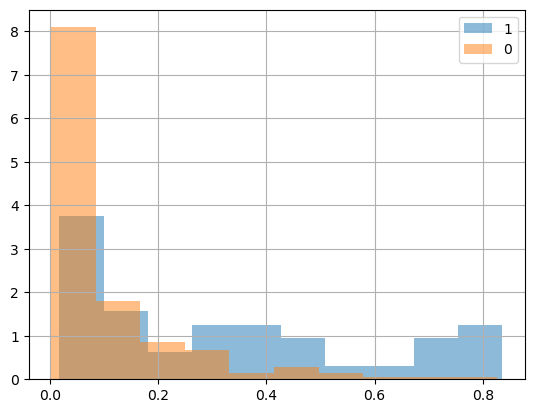

In [169]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

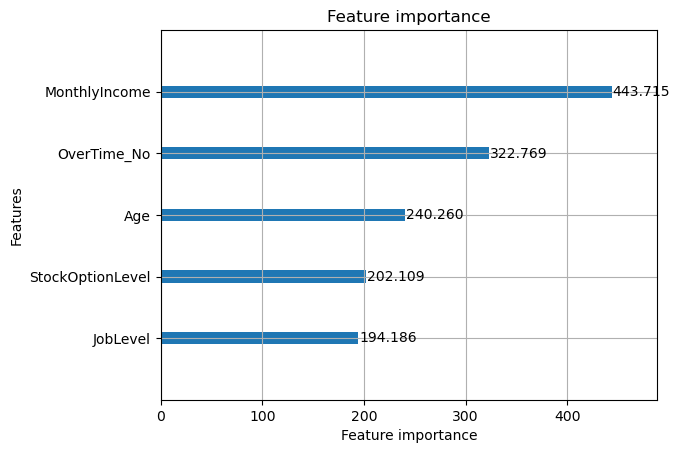

In [170]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

In [171]:
X_shap = X_test.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


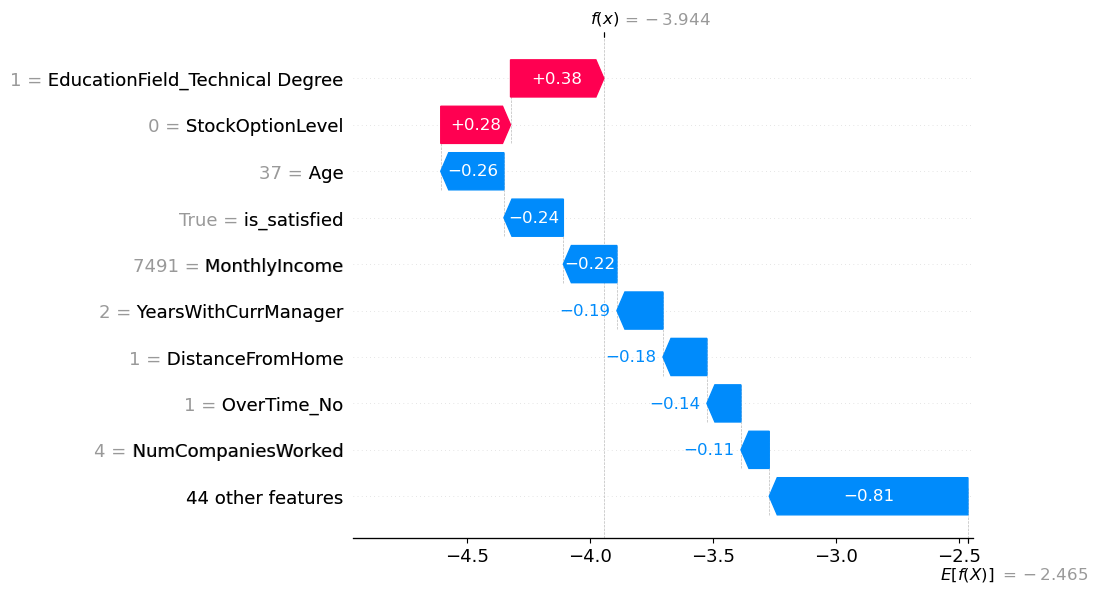

In [172]:
shap.initjs()
# Para visualizar shap individual con waterfall plot
# input: shap.Explanation(values=shaps[0])
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                    base_values = explainer.expected_value,
                    data=X_shap.iloc[0],
                    feature_names= X_shap.keys()))

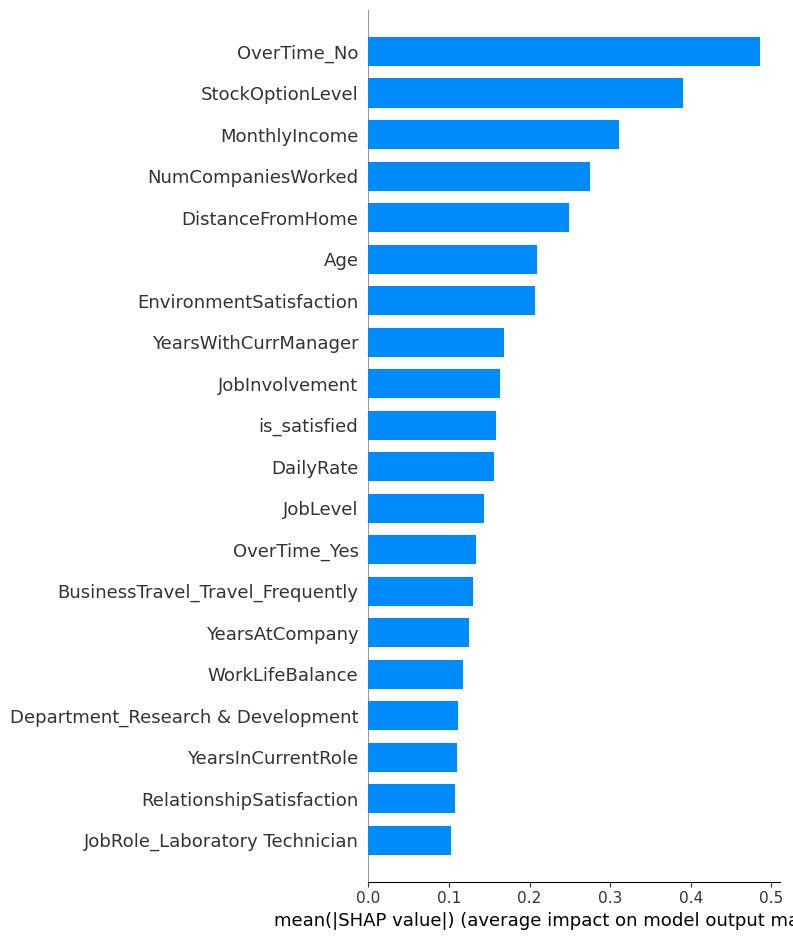

In [173]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

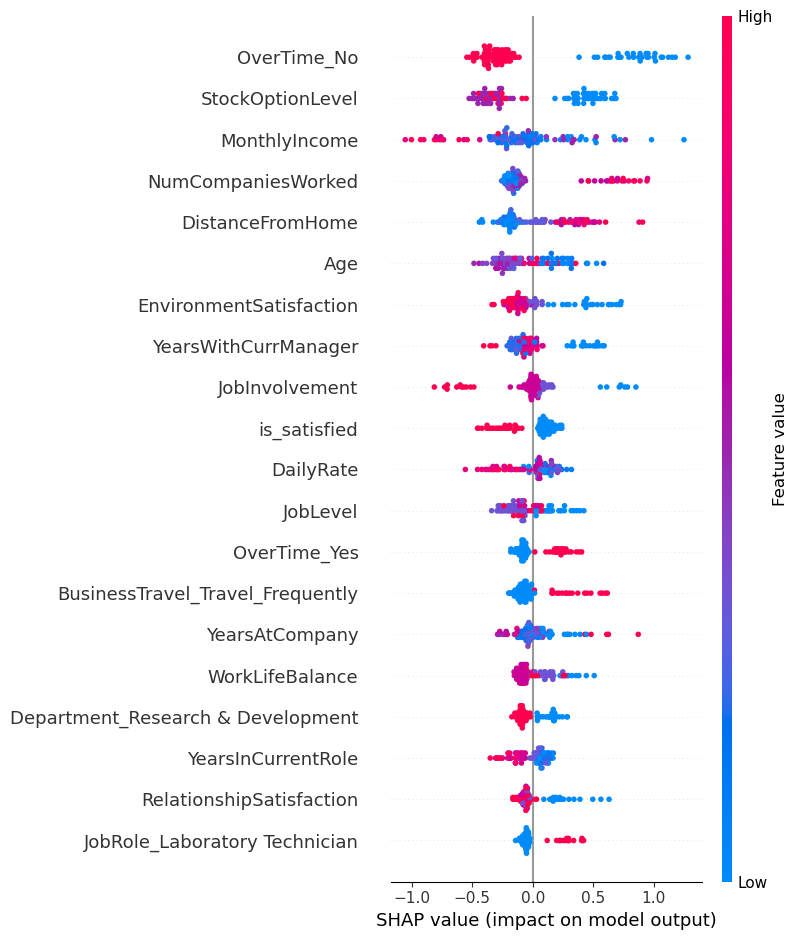

In [174]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

## LightGBM Todas Las Componentes

In [175]:
XC_train, XC_test, y_train, y_test = train_test_split(X_componentes, y, test_size=0.2, random_state=42)

In [176]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(XC_train, y_train, eval_set=[(XC_train, y_train), (XC_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.988876	valid_1's auc: 0.774661


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [177]:
best_model = model
probabilidades = best_model.predict_proba(XC_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7746606334841628

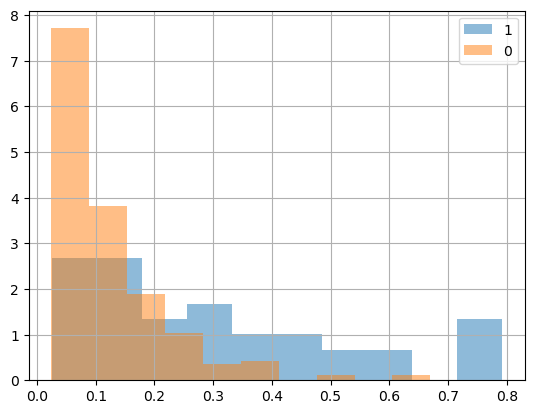

In [178]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

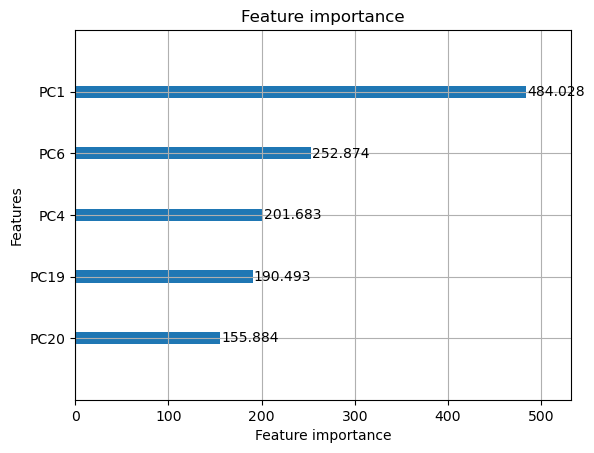

In [179]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

De acuerdo al feature importance realizado con los diferentes componentes podemos ver que los mas importantes son el 1, 6, 4, 19 y 20

## LightGBM Componentes Principales

In [184]:
XI_train, XI_test, y_train, y_test = train_test_split(X_componentes[['PC1', 'PC6','PC4','PC19']], y, test_size=0.2, random_state=42)

In [185]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(XI_train, y_train, eval_set=[(XI_train, y_train), (XI_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.834428	valid_1's auc: 0.666566


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [187]:
best_model = model
probabilidades = best_model.predict_proba(XI_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.6665661136249371

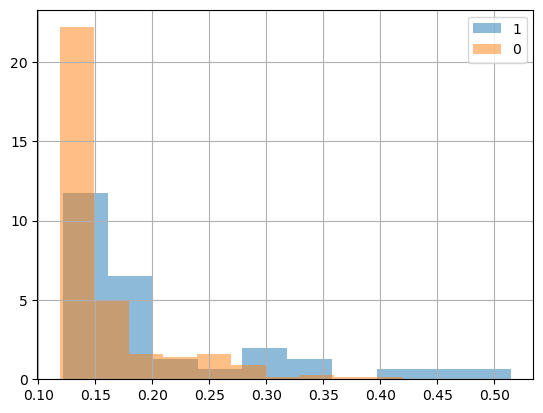

In [188]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

# Parte 2